
## Probabilistic Generative Models


In this notebook project, generative models, specifically normalizing flow networks and the variational autoencoder algorithm, will be used. A synthetic dataset will be created with a normalizing flow using randomized parameters. This dataset will then be used to train a variational autoencoder, and the trained model will be used to interpolate between the generated images. Concepts such as Distribution objects, probabilistic layers, bijectors, ELBO optimization, and KL divergence regularizers will be utilized.


First, run some imports and load the dataset:

In [7]:

from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model, Sequential

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For this project, an image dataset will be created from contour plots of a transformed distribution using a random normalizing flow network. The variational autoencoder algorithm will then be used to train generative and inference networks, and new images will be synthesized by interpolating in the latent space.

## 1. The Normalising Flow


To construct the image dataset, a normalizing flow is used to transform the 2-D Gaussian random variable $ z = (z_1, z_2) $, with a mean of $ \mathbf{0} $ and a covariance matrix of $ \Sigma = \sigma^2 \mathbf{I}_2 $, where $ \sigma = 0.3 $.

The normalizing flow employs bijectors that are parameterized as follows:
- $ \theta $ is sampled from $ U[0, 2\pi) $
- $ a $ is sampled from $ N(3, 1) $

The chain of transformations $ f_i(z) $, where $ i = 1, \ldots, 5 $, is defined as:

1. $ f_1(z) = (z_1, z_2 - 2) $
2. $ f_2(z) = (z_1, \frac{z_2}{2}) $
3. $ f_3(z) = (z_1, z_2 + az_1^2) $
4. $ f_4(z) = Rz $, where $ R $ is a rotation matrix with angle $ \theta $
5. $ f_5(z) = \tanh(z) $, applying the hyperbolic tangent function elementwise.

The transformed random variable $ x $ is calculated as $ x = f_5(f_4(f_3(f_2(f_1(z))))) $.

#### Implementation Steps

- Bijectors for each transformation $ f_i $ are implemented, with `log_det_jacobian` methods included as necessary.
- `tfb.Chain` and `tfb.TransformedDistribution` are employed to construct the final transformed distribution.
- A scatter plot of samples from the base distribution $ z $ is presented.
- Four scatter plots of the transformed distribution using samples of $ \theta $ and $ a $ are shown, with axes fixed to the range $ [-1, 1] $.




In [8]:

latent_distribution = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[0.4, 0.4])
latent_samples = latent_distribution.sample(2500)
print(latent_samples.shape)


(2500, 2)


In [9]:

class TransformA(tfb.Bijector):
  def __init__(self, factor, validate_args=False, name='transform_a', **kwargs):
    self.factor = factor
    super(TransformA, self).__init__(validate_args=validate_args,
                               forward_min_event_ndims=1,
                               name=name,
                               **kwargs)

  def _forward(self, x):
    zeros = tf.zeros(x.shape[:-1]+[1], dtype=x.dtype)
    values = x[..., 0, tf.newaxis]**2 * self.factor
    offset = tf.concat([zeros, values], axis=-1)
    return x + offset

  def _inverse(self, y):
    zeros = tf.zeros(y.shape[:-1]+[1], dtype=y.dtype)
    values = y[..., 0, tf.newaxis]**2 * self.factor
    offset = tf.concat([zeros, values], axis=-1)
    return y - offset

  def _forward_log_det_jacobian(self, x):
    value = 1 - 2 * self.factor * x[..., 1]
    return tf.math.log(tf.math.abs(value))

In [10]:

class TransformB(tfb.Bijector):
  def __init__(self, angle, validate_args=False, name='transform_b', **kwargs):
    self.angle = angle
    super(TransformB, self).__init__(validate_args=validate_args,
                               forward_min_event_ndims=1,
                               name=name,
                               is_constant_jacobian=True,
                               **kwargs)

  def _forward(self, x):
    x = tf.cast(x, tf.float32)
    angle = self.angle
    rotation = [[tf.math.cos(angle), -tf.math.sin(angle)], [tf.math.sin(angle), tf.math.cos(angle)]]
    x_transposed = np.moveaxis(x, -1, 0)
    x_rotated = tf.tensordot(rotation, x_transposed, axes=[[1], [0]])
    return np.moveaxis(x_rotated, 0, -1)

  def _inverse(self, y):
    y = tf.cast(y, tf.float32)
    angle = -self.angle
    rotation = [[tf.math.cos(angle), -tf.math.sin(angle)], [tf.math.sin(angle), tf.math.cos(angle)]]
    y_transposed = np.moveaxis(y, -1, 0)
    y_rotated = tf.tensordot(rotation, y_transposed, axes=[[1], [0]])
    return np.moveaxis(y_rotated, 0, -1)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

In [11]:

rotation_angle = 1.
rotation_matrix = [[tf.cos(rotation_angle), -tf.sin(rotation_angle)], [tf.sin(rotation_angle), tf.cos(rotation_angle)]]
linear_operator = tf.linalg.LinearOperatorFullMatrix(rotation_matrix)
tfp.bijectors.ScaleMatvecLinearOperator(linear_operator)

<tfp.bijectors.ScaleMatvecLinearOperator 'scale_matvec_linear_operator' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=float32 dtype_y=float32>

In [12]:

def create_composite_bijector(factor, angle):
  transformations = {}
  transformations['t5'] = tfb.Tanh()
  transformations['t4'] = TransformB(tf.Variable(angle, name='angle'))
  transformations['t3'] = TransformA(tf.Variable(factor, name='factor'))
  transformations['t2'] = tfb.Scale([1, 0.6])
  transformations['t1'] = tfb.Shift([0, -1.5])

  bijector_chain = list(transformations.values())
  return tfb.Chain(bijector_chain)

def generate_transformed_distribution(factor, angle):
  composite_bijector = create_composite_bijector(factor, angle)
  return tfd.TransformedDistribution(distribution=latent_distribution, bijector=composite_bijector)

In [13]:

transformed_distribution = generate_transformed_distribution(factor=1.2, angle=1.2)
sample_grid = (120, 120)
distribution_sample = transformed_distribution.sample(sample_grid)
print('distribution_sample.shape: ', distribution_sample.shape)

sample_probability = transformed_distribution.prob(distribution_sample)
print('sample_probability.shape: ', sample_probability.shape)

distribution_sample.shape:  (120, 120, 2)
sample_probability.shape:  (120, 120)


latent_points_shape:  (2500, 2)


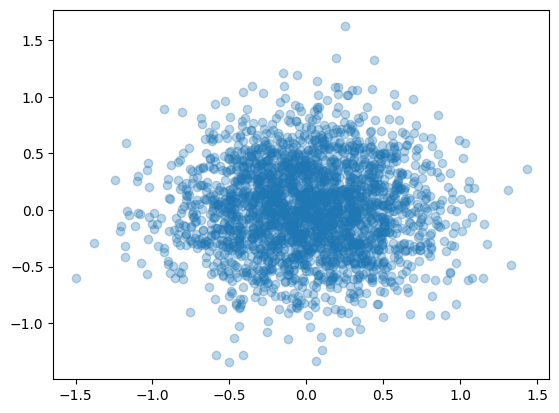

In [14]:

num_samples = 2500
latent_points = latent_distribution.sample(num_samples)
plt.scatter(latent_points[:,0], latent_points[:,1], alpha=0.3)
print('latent_points_shape: ', latent_points.shape)

transformed_points_shape:  (2500, 2)


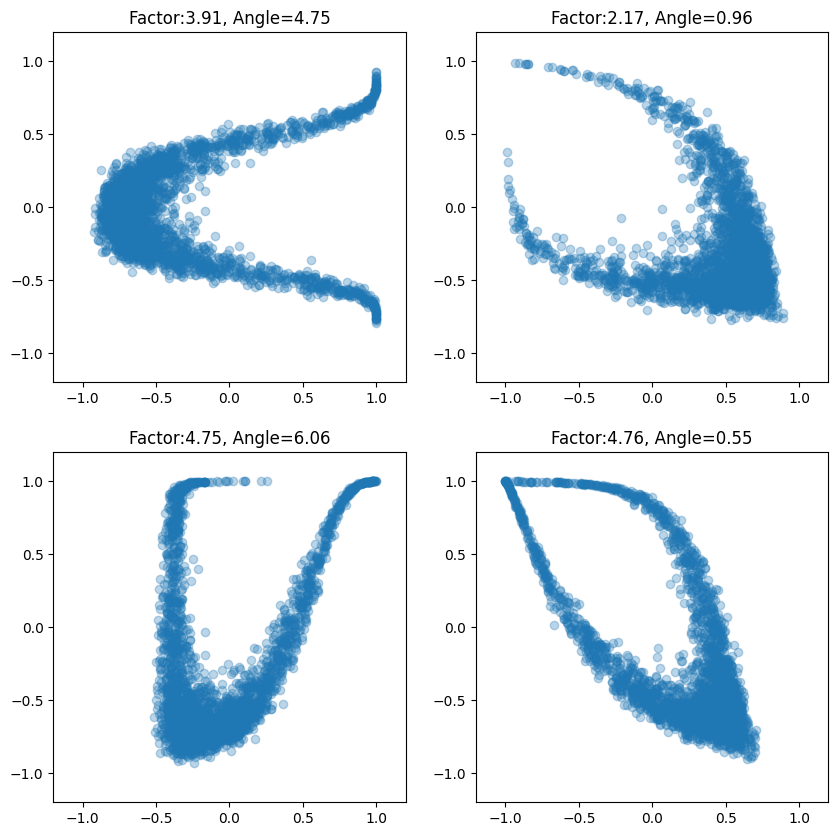

In [15]:

transformed_distribution = generate_transformed_distribution(factor=1.2, angle=1.2)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax in axes:
    random_angle = tf.squeeze(tf.random.uniform(shape=[1], minval=0, maxval=2*3.1415))
    random_factor = tf.squeeze(tf.random.normal(shape=[1], mean=3.5))
    transformed_distribution = generate_transformed_distribution(factor=random_factor, angle=random_angle)
    transformed_points = transformed_distribution.sample(num_samples)
    ax.set_title(f'Factor:{random_factor:.2f}, Angle={random_angle:.2f}')
    ax.scatter(transformed_points[:, 0], transformed_points[:, 1], alpha=0.3)
    plot_range = 1.2
    ax.set_xlim(-plot_range, plot_range)
    ax.set_ylim(-plot_range, plot_range)

print('transformed_points_shape: ', transformed_points.shape)



## 2. Create the Image Dataset
In the code below:
* The random normalizing flow is utilized to generate an image dataset of contour plots.
  * Various architectures are experimented with to produce diverse sets of images.
* Initially, display a sample of 4 contour plot images from the normalizing flow network using independently sampled sets of parameters. The `get_densities` function is employed for calculating density values necessary for contour plotting.
* The dataset consists of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`. Each image corresponds to a contour plot of a transformed distribution from a normalizing flow with independently sampled parameters \( s, T, S, b \).
  * Creation of this dataset may take a few minutes.
* Alongside the `get_densities` function, the `get_image_array_from_density_values` function is used to generate the dataset. This function creates a numpy array representing an image of the contour plot based on provided density values \( Z \).
  * Custom options can be chosen for the contour plots.
* Finally, display a sample of 20 images from the generated dataset in a figure.


In [16]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [17]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [18]:

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
coordinate_inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def compute_densities_for_distributions(transformed_distributions):
    batch_size = len(transformed_distributions)
    density_values = np.array([td.prob(coordinate_inputs) for td in transformed_distributions])
    return density_values

In [19]:
import tensorflow as tf
from scipy.ndimage import zoom

def resize_image(image, target_shape):
    """
    Resize the image to the target shape using zoom.
    """
    zoom_factors = [target_shape[0] / image.shape[0], target_shape[1] / image.shape[1], 1]
    return zoom(image, zoom_factors, order=1)

def generate_density_images(num_images):
    random_angles = tf.random.uniform(shape=[num_images], minval=0, maxval=2*3.1415)
    random_factors = tf.random.normal(shape=[num_images], mean=3.5)

    bijectors = [create_composite_bijector(factor, angle) for factor, angle in zip(random_factors, random_angles)]
    transformed_distributions = [tfd.TransformedDistribution(distribution=latent_distribution, bijector=bijector) for bijector in bijectors]
    density_values = compute_densities_for_distributions(transformed_distributions)

    raw_images = np.array([get_image_array_from_density_values(density) for density in density_values])
    resized_images = np.array([resize_image(image, (36, 36, 3)) for image in raw_images])

    return resized_images

In [20]:

density_images = generate_density_images(4)
print('density_images.shape:', density_images.shape)

density_images.shape: (4, 36, 36, 3)


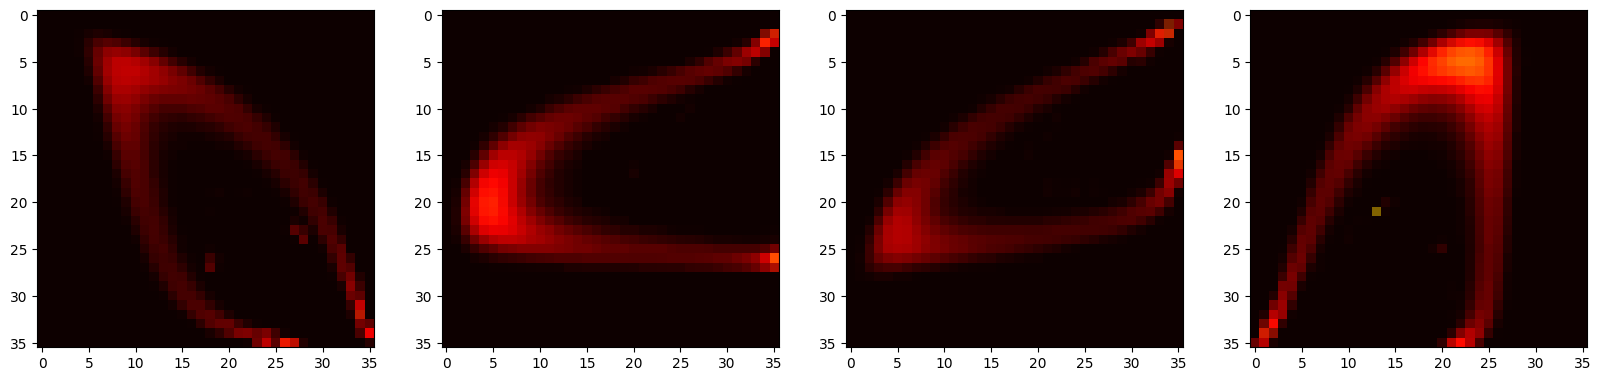

In [21]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
  axes[i].imshow(density_images[i])


In [22]:

density_images_large = generate_density_images(1200)
print(density_images_large.shape)


(1200, 36, 36, 3)


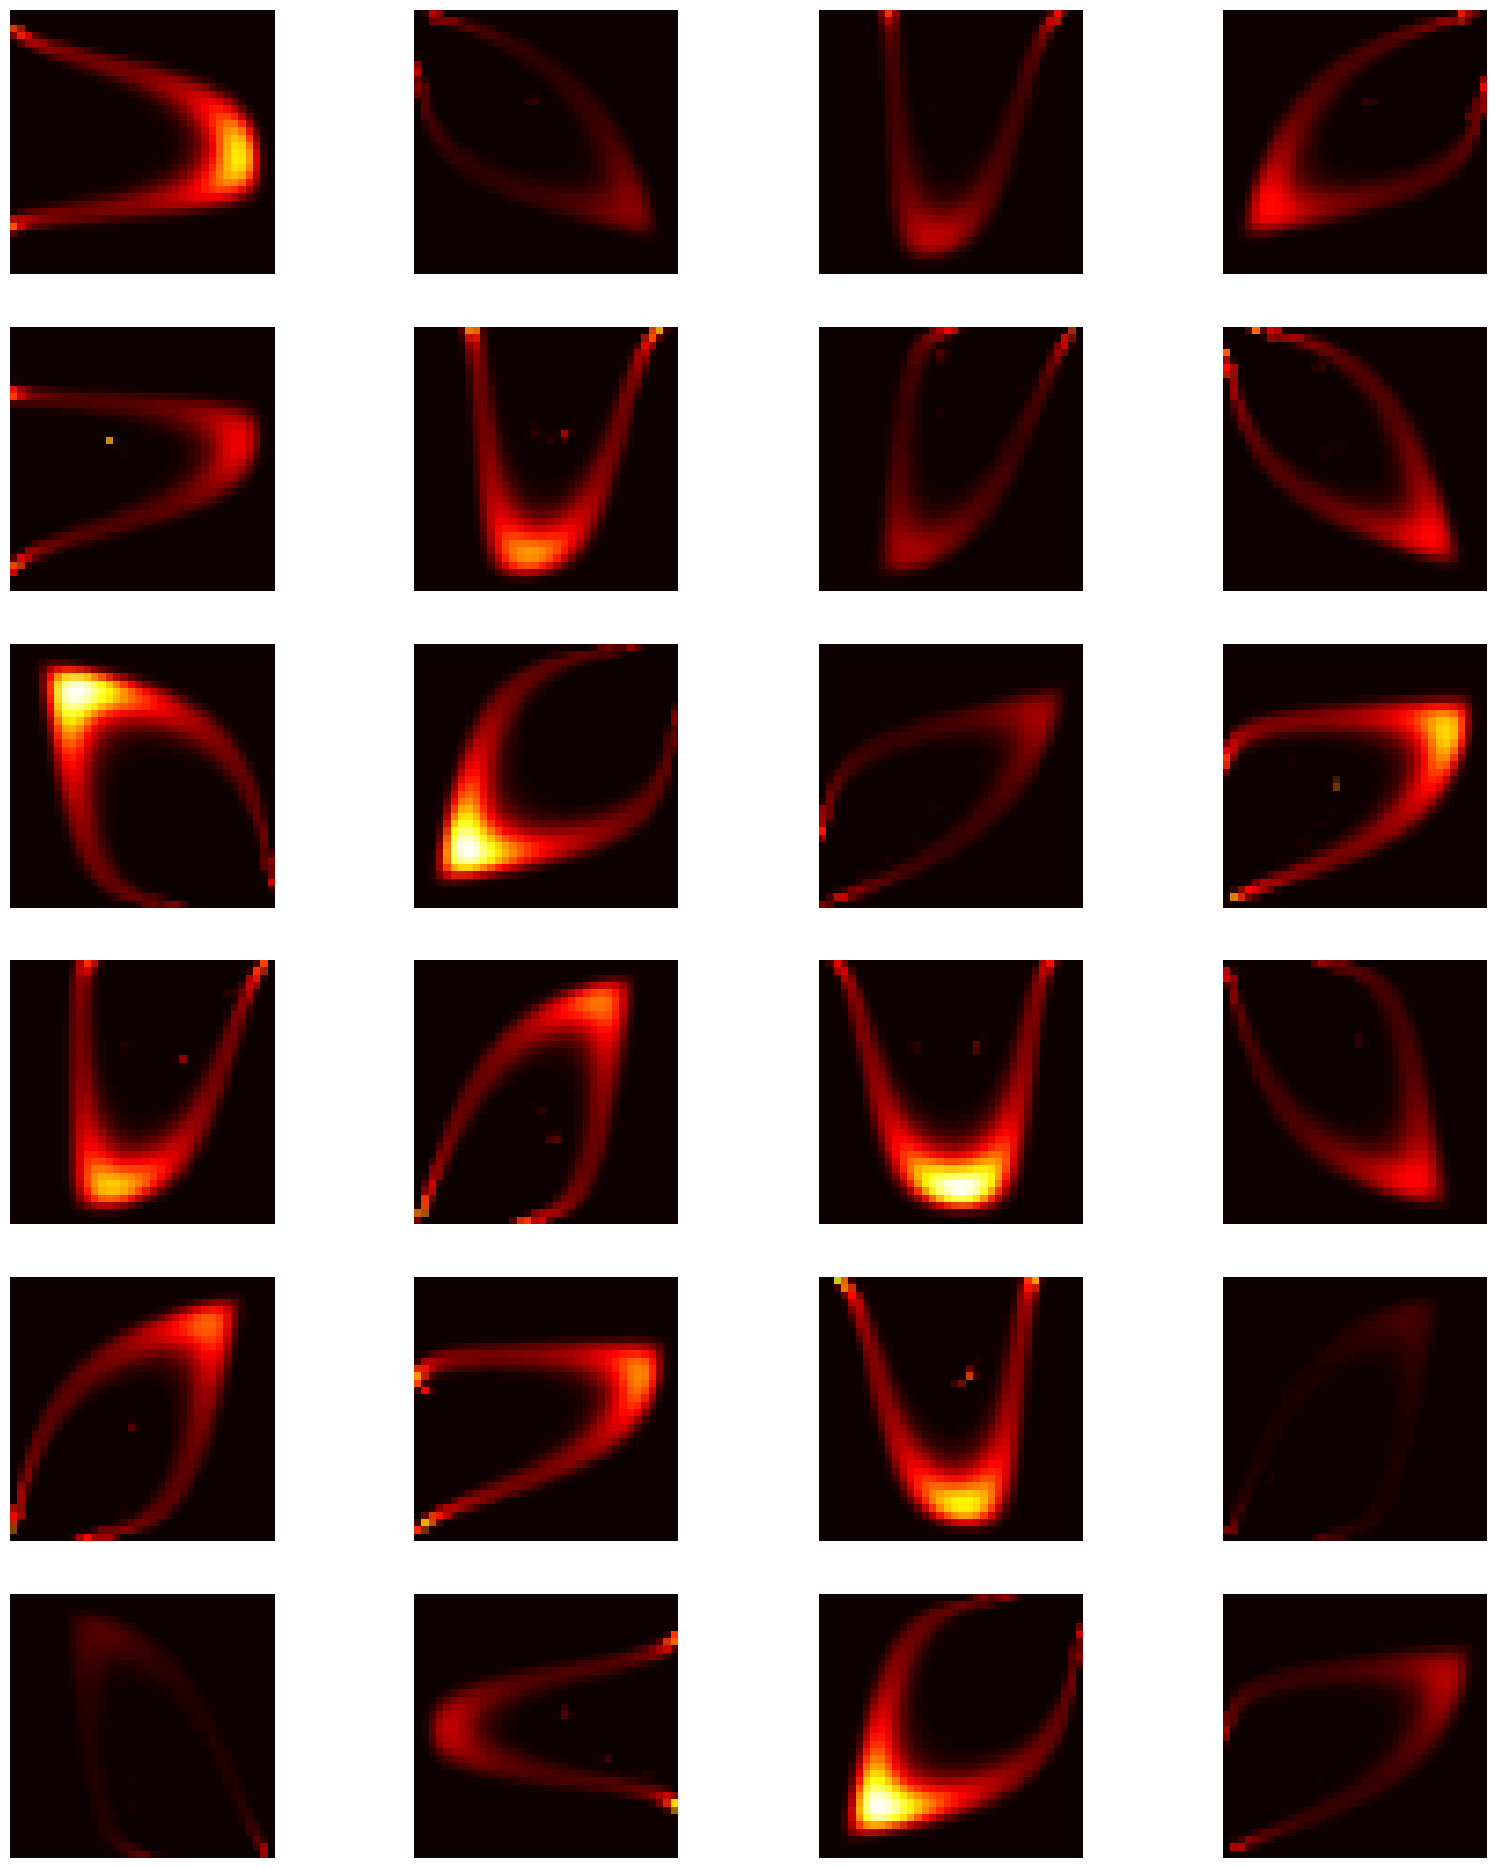

In [23]:


num_samples = 24
fig, axes = plt.subplots(6, 4, figsize=(20, 24))
sample_images = density_images_large[np.random.choice(range(len(density_images_large)), num_samples, replace=False)]
for ax, img in zip(axes.flatten(), sample_images):
  ax.imshow(img)
  ax.axis('off')




## 3. Make `tf.data.Dataset` Objects
In the code below:
* The dataset is split to create `tf.data.Dataset` objects for training and validation data.
* Using the `map` method, pixel values are normalized so that they range between 0 and 1.
* These Datasets are prepared for training a variational autoencoder (VAE), where the `map` method returns a tuple of input and output Tensors with each image duplicated as both input and output.
* The training Dataset is randomly shuffled.
* Both datasets are batched with a batch size of 20, using `drop_remainder=True`.
* The `element_spec` property for one of the Dataset objects is printed to inspect the structure of the data.


In [24]:

split_point = np.floor(len(density_images_large)*0.9).astype('int32')
print('training split: ', split_point)

train_dataset = tf.data.Dataset.from_tensor_slices(density_images_large[:split_point].astype('float32')).map(lambda x: x/255.)
test_dataset = tf.data.Dataset.from_tensor_slices(density_images_large[split_point:].astype('float32')).map(lambda x: x/255.)

train_dataset = train_dataset.map(lambda x: (x, x))
test_dataset = test_dataset.map(lambda x: (x, x))

train_dataset = train_dataset.shuffle(split_point)
test_dataset = test_dataset.shuffle(len(density_images_large)-split_point)

train_dataset = train_dataset.batch(20, drop_remainder=True)
test_dataset = test_dataset.batch(20, drop_remainder=True)

print(train_dataset.element_spec)

training split:  1080
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## 4. Build the Encoder and Decoder Networks
In the code below:

* The encoder and decoder for the variational autoencoder algorithm are created.
* These networks are designed using the `Sequential` class.
* Probabilistic layers are incorporated where necessary to represent distributions.
* The prior distribution is set to a zero-mean, isotropic Gaussian with an identity covariance matrix.
* The encoder network includes the KL divergence loss as part of the model.
* The model summary for both the encoder and decoder networks is printed to review their architectures.


In [25]:


latent_dimension = 2

def create_prior(latent_dimension):
    location = tf.Variable(tf.random.normal([latent_dimension]))
    scale_diagonal = tfp.util.TransformedVariable(initial_value=tf.ones((latent_dimension)), bijector=tfb.Softplus())
    return tfd.MultivariateNormalDiag(loc=location, scale_diag=scale_diagonal)

prior_distribution = create_prior(latent_dimension)

In [26]:


def create_kl_regularizer(prior_distribution):
    return tfpl.KLDivergenceRegularizer(
        distribution_b=prior_distribution,
        weight=1.0,
        test_points_fn=lambda dist: dist.sample(3),
        test_points_reduce_axis=None,
    )

kl_regularizer = create_kl_regularizer(prior_distribution)


In [27]:


import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def create_encoder(input_shape, latent_dimension, kl_regularizer):
    conv2D_params = {'activation':'relu', 'padding':'SAME', 'strides':(2,2), 'kernel_size':(4,4)}
    return Sequential([
        Conv2D(32, **conv2D_params, input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, **conv2D_params),
        BatchNormalization(),
        Conv2D(128, **conv2D_params),
        BatchNormalization(),
        Conv2D(256, **conv2D_params),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dimension)),
        tfpl.MultivariateNormalTriL(
            latent_dimension,
            activity_regularizer=kl_regularizer
        ),
    ])

encoder_model = create_encoder((36, 36, 3), latent_dimension, kl_regularizer)
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 32)        1568      
                                                                 
 batch_normalization (Batch  (None, 18, 18, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 batch_normalization_1 (Bat  (None, 9, 9, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         131200    
                                                                 
 batch_normalization_2 (Bat  (None, 5, 5, 128)         5

In [28]:


def create_decoder(output_shape, latent_dimension):
    conv2D_params = {'kernel_size':(3,3), 'activation':'relu', 'padding':'SAME'}

    return Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dimension,)),
        Reshape((4, 4, 256)),
        UpSampling2D((2,2)),
        Conv2D(128, **conv2D_params),
        UpSampling2D((2,2)),
        Conv2D(64, **conv2D_params),
        UpSampling2D((2,2)),
        Conv2D(32, **conv2D_params),
        UpSampling2D((2,2)),
        Conv2D(128, **conv2D_params),
        Conv2D(3, (3,3), padding='SAME'),
        Flatten(),
        Dense(tfpl.IndependentBernoulli.params_size(output_shape)),
        tfpl.IndependentBernoulli(output_shape)
    ])

decoder_model = create_decoder((36, 36, 3), latent_dimension)

decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              12288     
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

## 5. Train the Variational Autoencoder
In the code below:
* The variational autoencoder (VAE) is built using the `Model` class, incorporating the previously created encoder and decoder models. The model summary is printed for review.
* The VAE is compiled with the negative log likelihood loss and trained using the `fit` method, utilizing the training and validation Datasets.
* Learning curves depicting loss versus epoch for both the training and validation sets are plotted.


In [29]:


vae_model = Model(inputs=encoder_model.inputs, outputs=decoder_model(encoder_model.outputs))
vae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 32)        1568      
                                                                 
 batch_normalization (Batch  (None, 18, 18, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 batch_normalization_1 (Bat  (None, 9, 9, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         131200

In [30]:
def reconstruction_loss_function(original_batch, reconstructed_distribution):
    return -tf.reduce_mean(reconstructed_distribution.log_prob(original_batch))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

vae_model.compile(optimizer=optimizer, loss=reconstruction_loss_function)

training_history = vae_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50
)


Epoch 1/50
54/54 [==============================] - 13s 39ms/step - loss: 834.1714 - val_loss: 689.2539
Epoch 2/50
54/54 [==============================] - 1s 22ms/step - loss: 581.5267 - val_loss: 631.4537
Epoch 3/50
54/54 [==============================] - 1s 22ms/step - loss: 544.0144 - val_loss: 644.4078
Epoch 4/50
54/54 [==============================] - 1s 22ms/step - loss: 526.8650 - val_loss: 646.3869
Epoch 5/50
54/54 [==============================] - 1s 22ms/step - loss: 513.9103 - val_loss: 664.2055
Epoch 6/50
54/54 [==============================] - 1s 24ms/step - loss: 504.6582 - val_loss: 623.4758
Epoch 7/50
54/54 [==============================] - 1s 23ms/step - loss: 508.1906 - val_loss: 589.5147
Epoch 8/50
54/54 [==============================] - 1s 22ms/step - loss: 493.2966 - val_loss: 535.1307
Epoch 9/50
54/54 [==============================] - 1s 22ms/step - loss: 489.4915 - val_loss: 492.3559
Epoch 10/50
54/54 [==============================] - 1s 22ms/step - loss

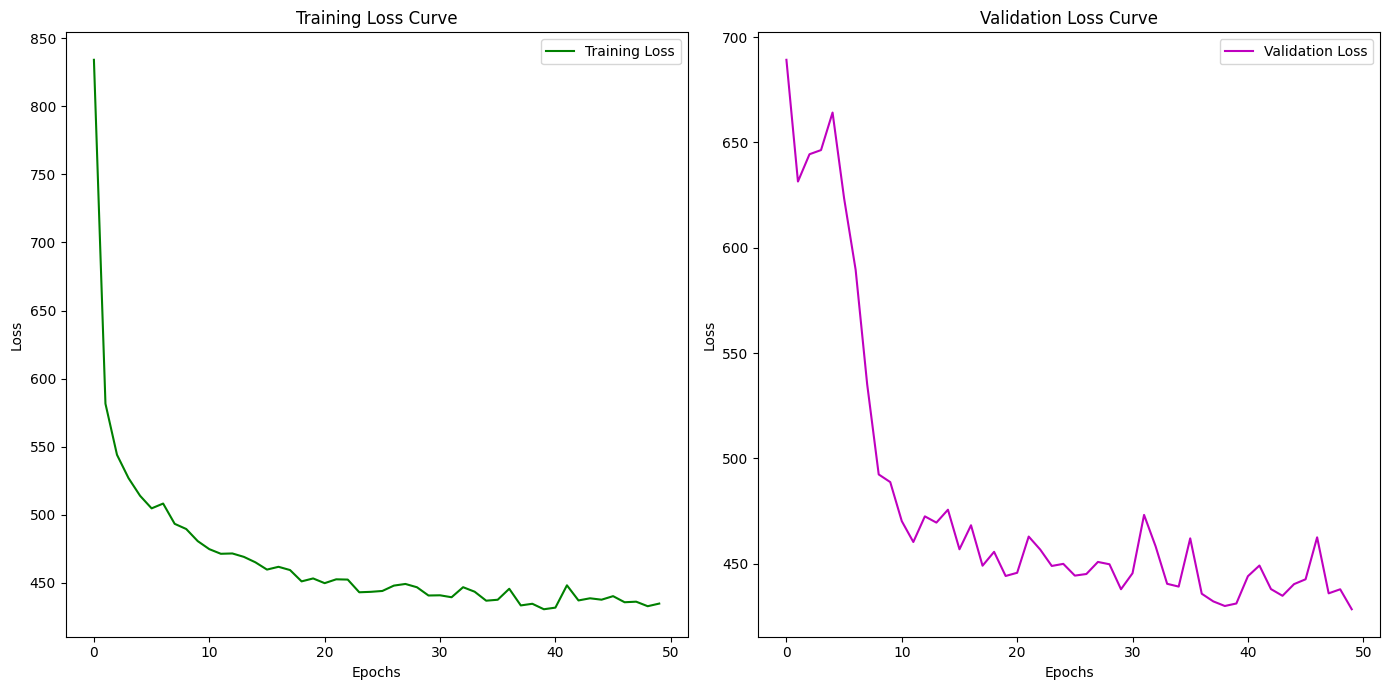

In [31]:


import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.plot(training_history.history.get('loss'), label='Training Loss', color='g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

ax2.plot(training_history.history.get('val_loss'), label='Validation Loss', color='m')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss Curve')
ax2.legend()

plt.tight_layout()
plt.show()


## 6. Use the Encoder and Decoder Networks
In the code below:

* The encoder and decoder networks are now utilized.
* 1000 images are randomly sampled from the dataset and passed through the encoder. The embeddings are displayed in a scatter plot, projected to 2 dimensions if the latent space dimension is higher.
* 4 images are randomly sampled from the dataset. For each image, the original and reconstructed images from the VAE are displayed in a figure, using the mean of the output distribution.
* 6 latent variable realizations are randomly sampled from the prior distribution, and the corresponding images are displayed in a figure, again using the mean of the output distribution to display the images.

In [32]:

density_images_large = density_images_large.astype('float32') / 255.0

encoded_representations = encoder_model(density_images_large)
print('density_images_large.shape: ', density_images_large.shape)
print('encoded_representations: ', encoded_representations)

density_images_large.shape:  (1200, 36, 36, 3)
encoded_representations:  tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1200], event_shape=[2], dtype=float32)


In [33]:

encoded_representation_samples = encoded_representations.sample()
print('encoded_representation_samples: ', encoded_representation_samples.shape)

encoded_representation_samples:  (1200, 2)


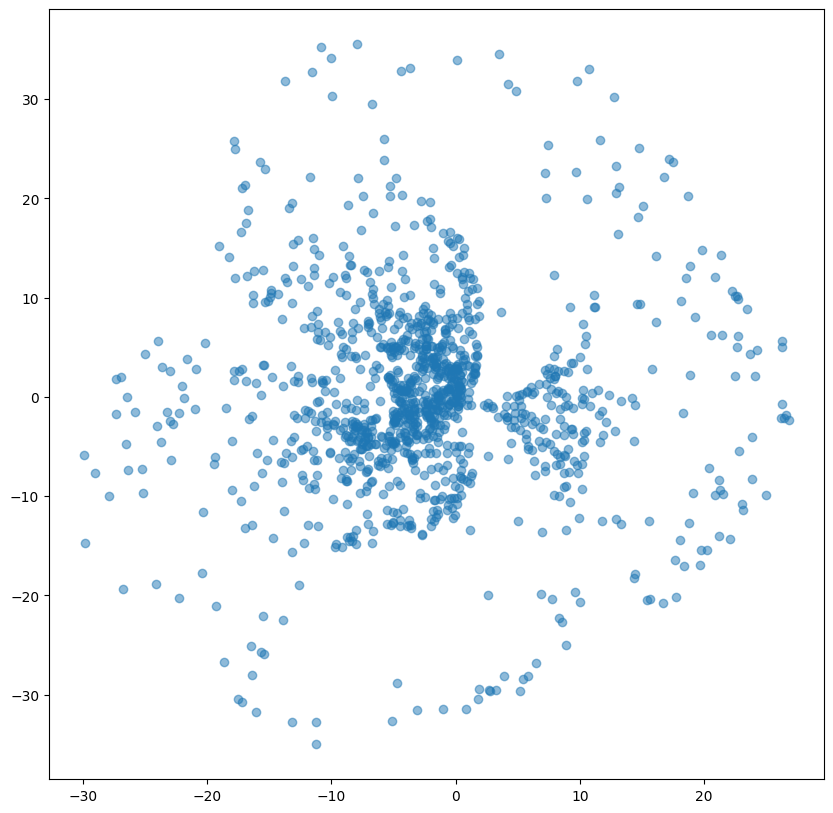

In [34]:

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.scatter(encoded_representation_samples[:, 0], encoded_representation_samples[:, 1], alpha=0.5)


In [35]:

def reconstruct_images(encoder, decoder, image_batch):
    encoder_mean = encoder(image_batch).mean()
    return decoder(encoder_mean).mean()

num_reconstructions = 4
selected_indices = np.random.choice(len(density_images_large), num_reconstructions, replace=False)
example_images = density_images_large[selected_indices]
print('selected_indices: ', selected_indices)
print('example_images.shape: ', example_images.shape)

reconstructed_images = reconstruct_images(encoder_model, decoder_model, example_images).numpy()
print('reconstructed_images.shape: ', reconstructed_images.shape)


selected_indices:  [600 251 291 551]
example_images.shape:  (4, 36, 36, 3)
reconstructed_images.shape:  (4, 36, 36, 3)


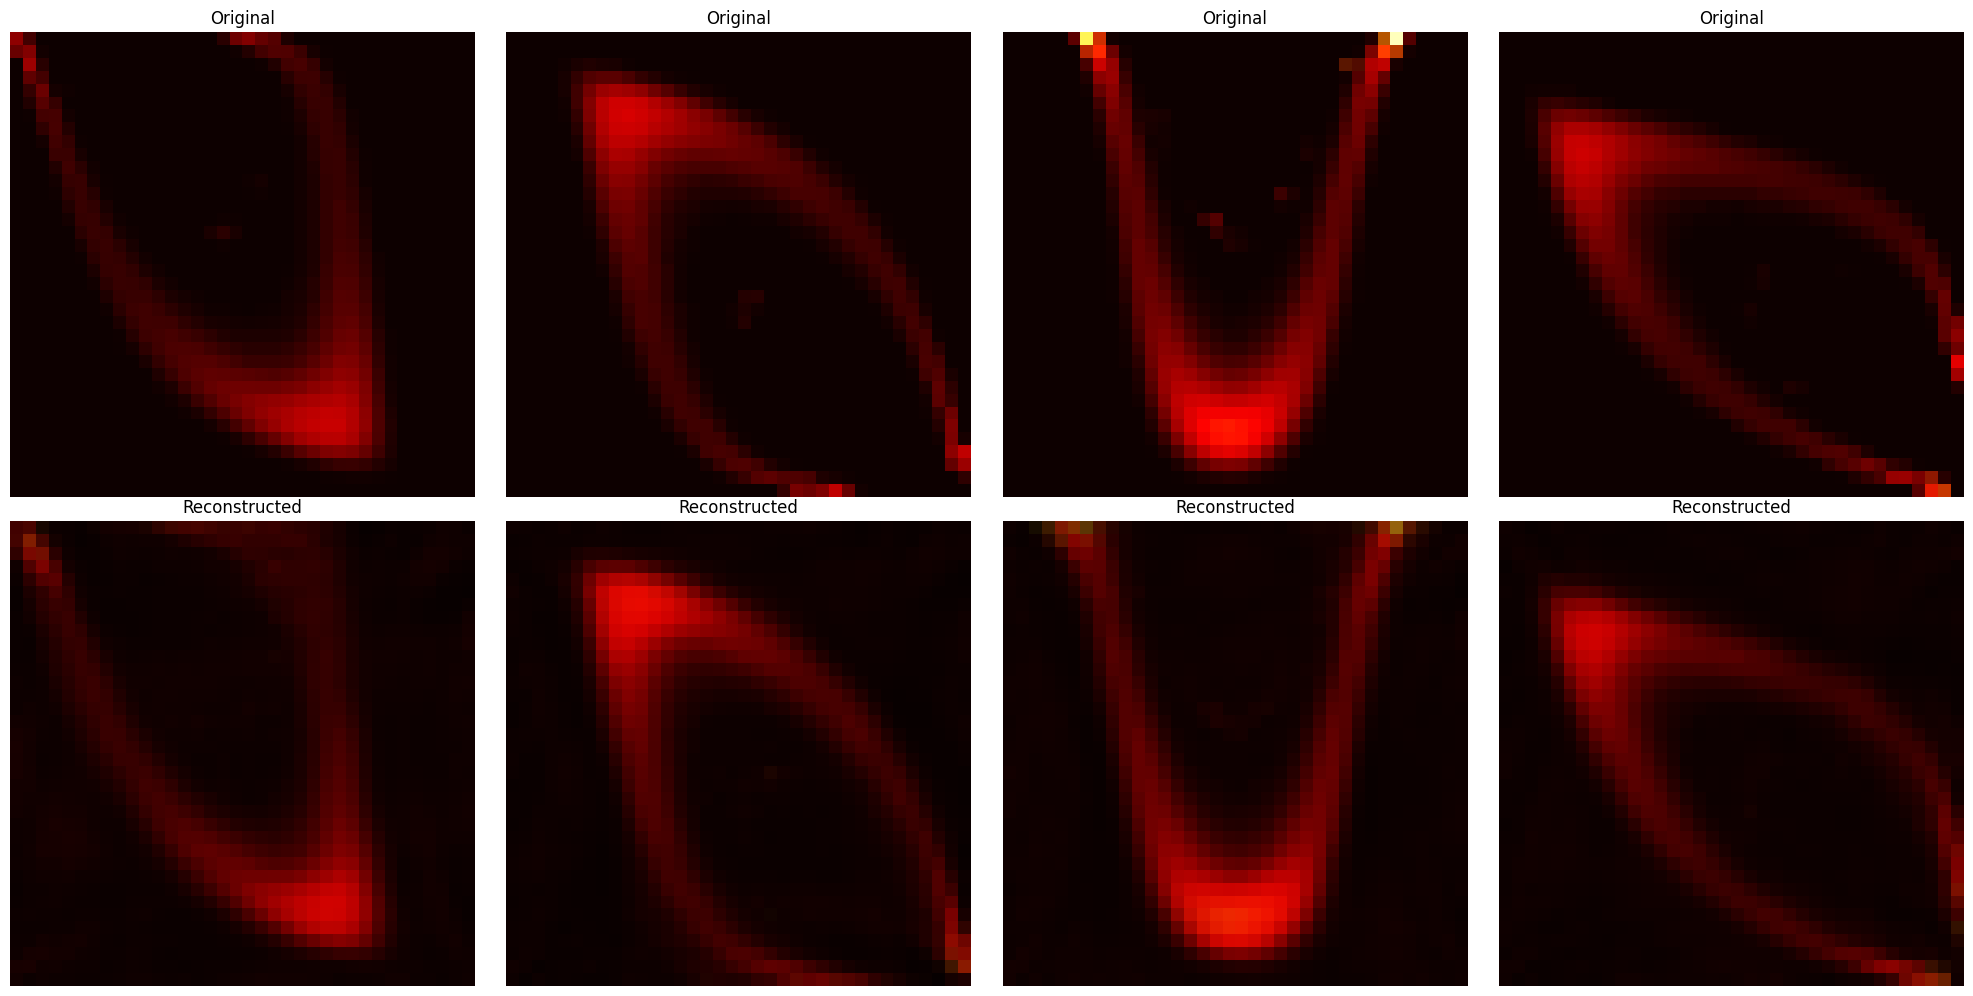

In [36]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for original, reconstructed, (ax1, ax2) in zip(example_images, reconstructed_images, axs.T):
    ax1.set_title('Original')
    ax1.imshow(original)
    ax2.set_title('Reconstructed')
    ax2.imshow(reconstructed)
    ax1.axis('off')
    ax2.axis('off')

plt.tight_layout()
plt.show()

## Make a video of latent space interpolation
* The code below can be run to create a video of the decoder's generations, depending on the latent space.

In [37]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i):
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length,
                              repeat=False, blit=True, interval=150)

<ipython-input-37-8477254a2d74>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(z.numpy()[0], z.numpy()[1])
<ipython-input-37-8477254a2d74>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(z.numpy()[0], z.numpy()[1])


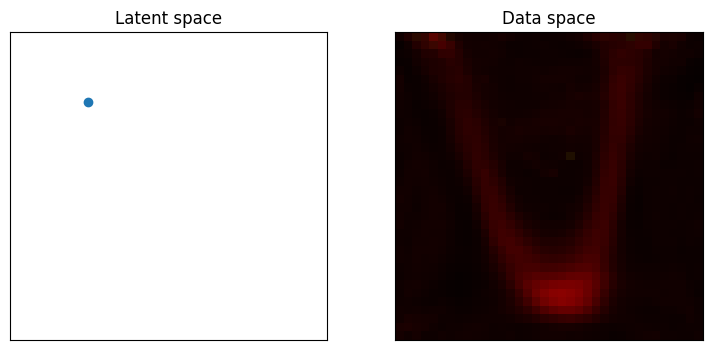

In [38]:
# Create the animation

latent_dimension = 2  
a = get_animation(latent_dimension, decoder_model, interpolation_length=200)
HTML(a.to_html5_video())